In [ ]:
!pip install netcdf4
!pip install cartopy
!pip install xarray netcdf4 matplotlib cartopy
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
from scipy import stats
import os
import xarray as xr
import cartopy.feature as cfeature
# accessing files in google drive
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
# Read the CSV file
file_path = "/content/drive/MyDrive/Colab Notebooks/EAS 2750/Hurricane Data North Atlantic.csv"

df = pd.read_csv(file_path)

# Display basic info about the dataset
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nColumn names:")
print(df.columns.tolist())
print("\nSample of Date column:")
print(df['Date'].head(10))

Dataset shape: (79, 6)

First few rows:
  Hurricane Name  Year           Date  Maximun Sustained Wind Speeds (knots)  \
0          Debby  2024  03 Aug–08 Aug                                     70   
1        Ernesto  2024  12 Aug–20 Aug                                     85   
2       Francine  2024  09 Sep–12 Sep                                     90   
3          Isaac  2024  25 Sep–30 Sep                                     90   
4         Leslie  2024  02 Oct–12 Oct                                     90   

   Minimium Central Pressure (mb)  Accumulated Cyclone Energy (x10^4 kt^2)  
0                             979                                      4.9  
1                             967                                     14.4  
2                             972                                      4.8  
3                             963                                      7.9  
4                             970                                     16.1  

Column names:
['


Unique date formats in first 20 entries:
0: 03 Aug–08 Aug (type: <class 'str'>)
1: 12 Aug–20 Aug (type: <class 'str'>)
2: 09 Sep–12 Sep (type: <class 'str'>)
3: 25 Sep–30 Sep (type: <class 'str'>)
4: 02 Oct–12 Oct (type: <class 'str'>)
5: 19 Oct–22 Oct (type: <class 'str'>)
6: 01 Sep–08 Sep (type: <class 'str'>)
7: 02 Sep–10 Sep (type: <class 'str'>)
8: 07 Oct–09 Oct (type: <class 'str'>)
9: 31 Oct–05 Nov (type: <class 'str'>)
10: 01 Nov–03 Nov (type: <class 'str'>)
11: 07 Nov–11 Nov (type: <class 'str'>)
12: 23 Jul–26 Jul (type: <class 'str'>)
13: 30 Jul–04 Aug (type: <class 'str'>)
14: 21 Aug–25 Aug (type: <class 'str'>)
15: 01 Sep–03 Sep (type: <class 'str'>)
16: 07 Sep–22 Sep (type: <class 'str'>)
17: 11 Sep–17 Sep (type: <class 'str'>)
18: 02 Oct–06 Oct (type: <class 'str'>)
19: 04 Jul–15 Jul (type: <class 'str'>)

After initial parsing:
0    03 Aug
1    12 Aug
2    09 Sep
3    25 Sep
4    02 Oct
5    19 Oct
6    01 Sep
7    02 Sep
8    07 Oct
9    31 Oct
Name: Date_parsed, dtype

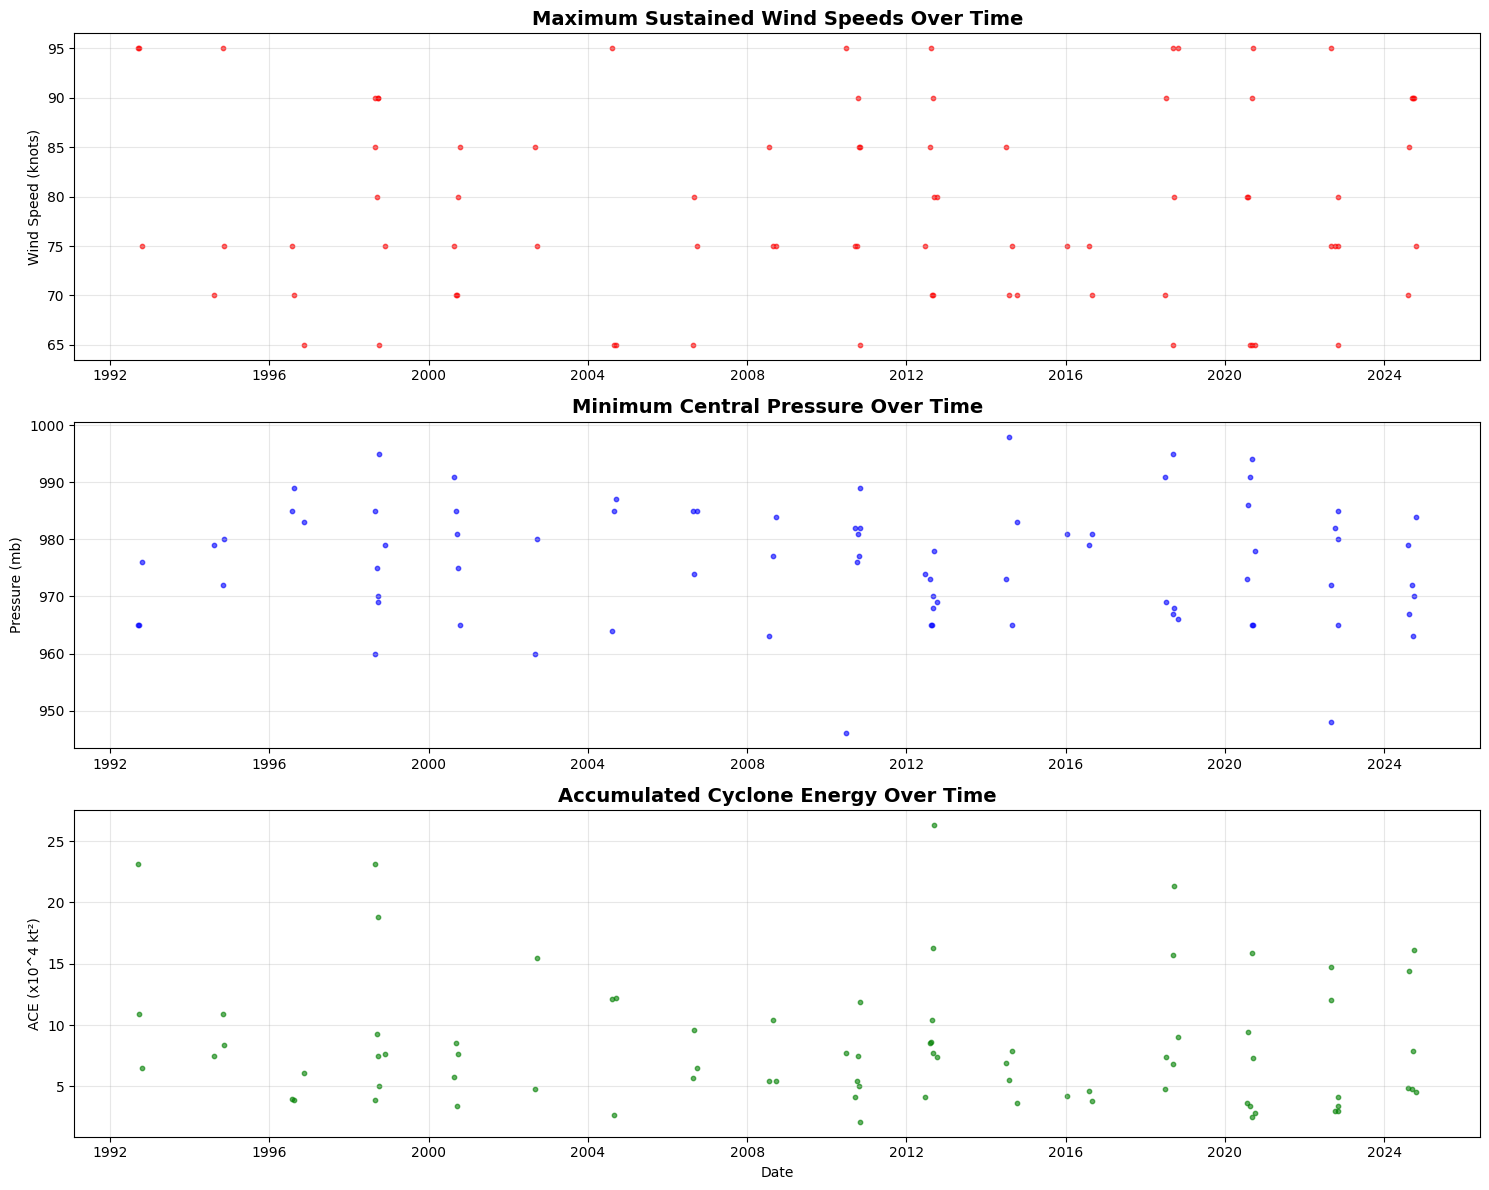

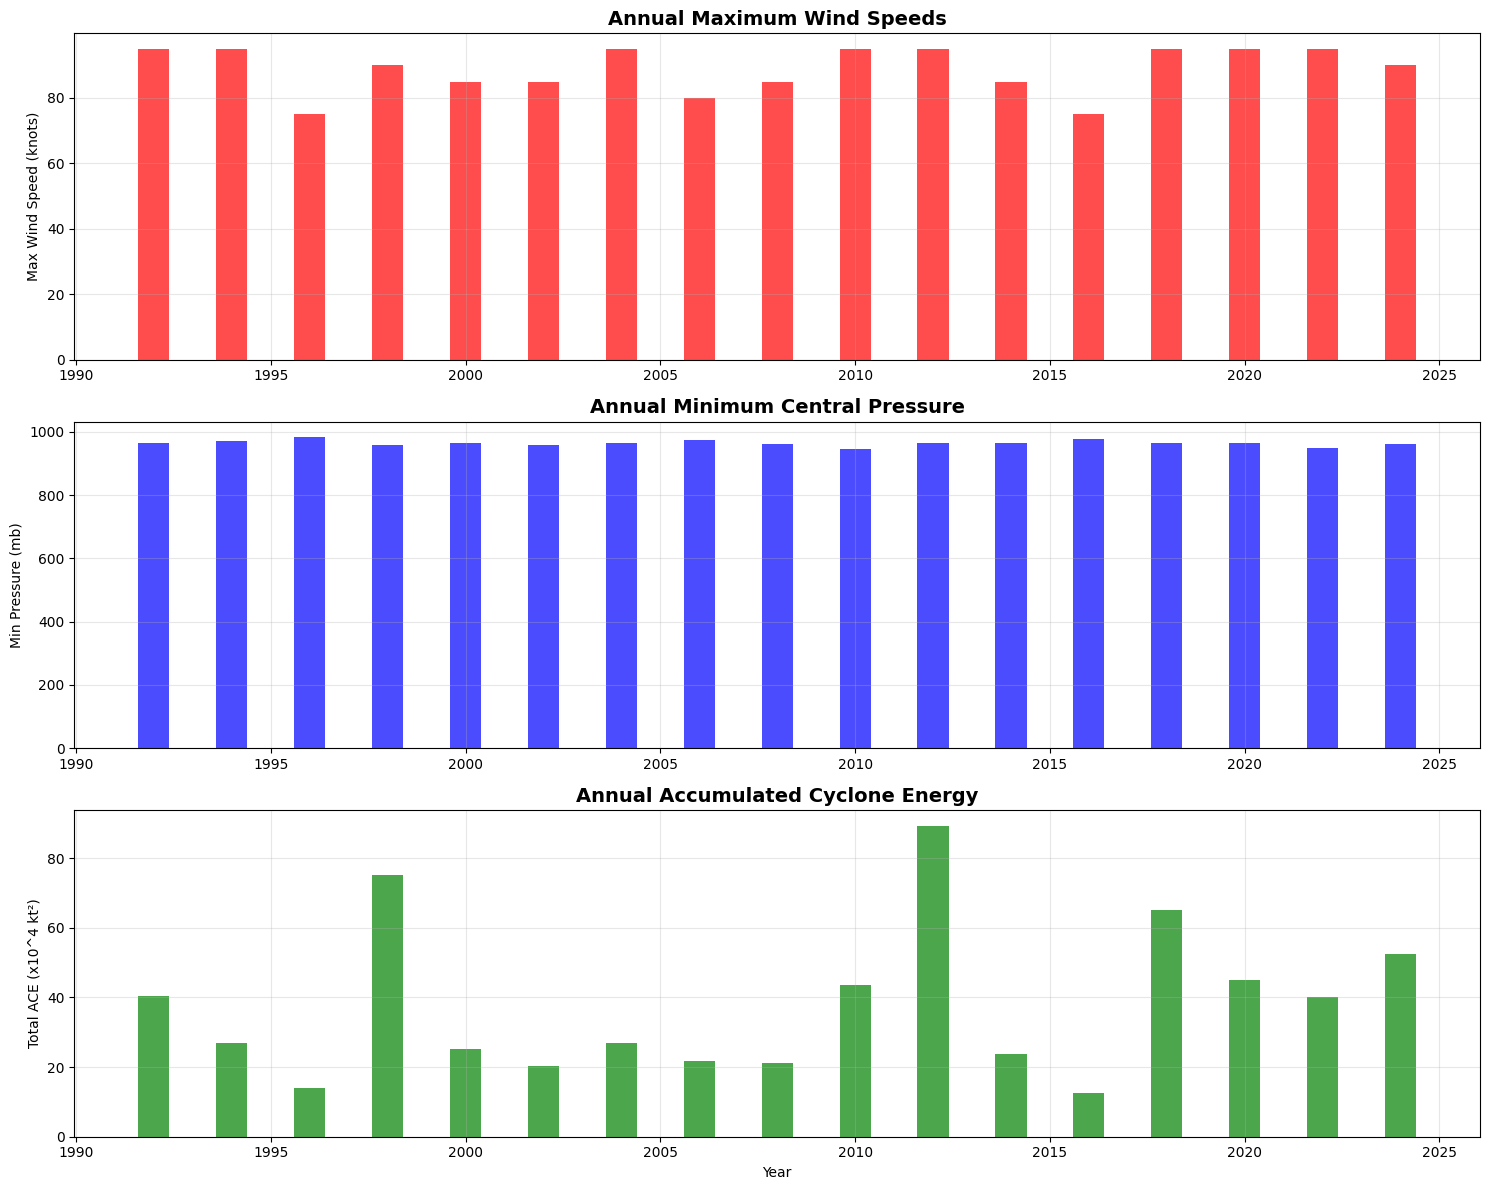


Basic Statistics:
Maximum Wind Speeds:
  Max: 95 knots
  Min: 65 knots
  Mean: 79.05 knots

Minimum Central Pressure:
  Max: 998 mb
  Min: 946 mb
  Mean: 975.92 mb

Accumulated Cyclone Energy:
  Max: 26.3
  Min: 2.1
  Mean: 8.2603


In [ ]:
# Let's examine the date format more carefully
print("\nUnique date formats in first 20 entries:")
for i, date_val in enumerate(df['Date'].head(20)):
    print(f"{i}: {date_val} (type: {type(date_val)})")

# Function to parse hurricane dates (handles ranges like "03 Aug–08 Aug")
def parse_hurricane_date(date_str):
    """
    Parse hurricane date strings that might be ranges.
    For ranges, we'll use the start date.
    """
    if pd.isna(date_str):
        return pd.NaT

    # Convert to string if it's not already
    date_str = str(date_str)

    # Handle date ranges (e.g., "03 Aug–08 Aug")
    if '–' in date_str or '-' in date_str:
        # Split on the range character and take the first part
        if '–' in date_str:  # en dash
            start_date = date_str.split('–')[0].strip()
        else:  # regular hyphen
            start_date = date_str.split('-')[0].strip()

        # Add year (we'll need to handle this - might need to get from Year column)
        return start_date
    else:
        return date_str

# Apply the parsing function
df['Date_parsed'] = df['Date'].apply(parse_hurricane_date)

# Now let's see what we have after initial parsing
print("\nAfter initial parsing:")
print(df['Date_parsed'].head(10))

# We need to combine with year information since dates don't include year
# Create a proper datetime by combining with Year column
def create_full_date(row):
    """
    Create a proper datetime by combining parsed date with year
    """
    try:
        if pd.isna(row['Date_parsed']) or pd.isna(row['Year']):
            return pd.NaT

        date_str = str(row['Date_parsed']).strip()
        year = int(row['Year'])

        # Try different date formats
        formats_to_try = [
            '%d %b',  # "03 Aug"
            '%b %d',  # "Aug 03" (if format is different)
            '%d %B',  # "03 August"
            '%B %d',  # "August 03"
        ]

        for fmt in formats_to_try:
            try:
                # Parse the date without year
                date_obj = pd.to_datetime(date_str + f' {year}', format=f'{fmt} %Y')
                return date_obj
            except:
                continue

        # If none of the formats work, return NaT
        return pd.NaT

    except Exception as e:
        print(f"Error parsing date: {row['Date_parsed']} with year {row['Year']}: {e}")
        return pd.NaT

# Apply the date creation function
df['Date_datetime'] = df.apply(create_full_date, axis=1)

# Check for any parsing failures
failed_dates = df[df['Date_datetime'].isna()]
if len(failed_dates) > 0:
    print(f"\nFailed to parse {len(failed_dates)} dates. Samples:")
    print(failed_dates[['Date', 'Year', 'Date_parsed']].head(10))

# Remove rows where date parsing failed
df_clean = df.dropna(subset=['Date_datetime']).copy()

print(f"\nOriginal dataset: {len(df)} rows")
print(f"After date cleaning: {len(df_clean)} rows")

# Sort by date to ensure proper time series
df_clean = df_clean.sort_values('Date_datetime')

# Create time series plots
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# 1. Maximum Sustained Wind Speeds time series
axes[0].scatter(df_clean['Date_datetime'], df_clean['Maximun Sustained Wind Speeds (knots)'],
               alpha=0.6, color='red', s=10)
axes[0].set_title('Maximum Sustained Wind Speeds Over Time', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Wind Speed (knots)')
axes[0].grid(True, alpha=0.3)

# 2. Minimum Central Pressure time series
axes[1].scatter(df_clean['Date_datetime'], df_clean['Minimium Central Pressure (mb)'],
               alpha=0.6, color='blue', s=10)
axes[1].set_title('Minimum Central Pressure Over Time', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Pressure (mb)')
axes[1].grid(True, alpha=0.3)

# 3. Accumulated Cyclone Energy time series
axes[2].scatter(df_clean['Date_datetime'], df_clean['Accumulated Cyclone Energy (x10^4 kt^2)'],
               alpha=0.6, color='green', s=10)
axes[2].set_title('Accumulated Cyclone Energy Over Time', fontsize=14, fontweight='bold')
axes[2].set_ylabel('ACE (x10^4 kt²)')
axes[2].set_xlabel('Date')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Optional: Create yearly aggregated plots to see trends better
df_clean['Year'] = df_clean['Date_datetime'].dt.year

# Group by year and calculate annual statistics
annual_stats = df_clean.groupby('Year').agg({
    'Maximun Sustained Wind Speeds (knots)': 'max',
    'Minimium Central Pressure (mb)': 'min',
    'Accumulated Cyclone Energy (x10^4 kt^2)': 'sum'
}).reset_index()

# Create annual trend plots
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Annual maximum wind speeds
axes[0].bar(annual_stats['Year'], annual_stats['Maximun Sustained Wind Speeds (knots)'],
            color='red', alpha=0.7)
axes[0].set_title('Annual Maximum Wind Speeds', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Max Wind Speed (knots)')
axes[0].grid(True, alpha=0.3)

# Annual minimum pressure
axes[1].bar(annual_stats['Year'], annual_stats['Minimium Central Pressure (mb)'],
            color='blue', alpha=0.7)
axes[1].set_title('Annual Minimum Central Pressure', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Min Pressure (mb)')
axes[1].grid(True, alpha=0.3)

# Annual total ACE
axes[2].bar(annual_stats['Year'], annual_stats['Accumulated Cyclone Energy (x10^4 kt^2)'],
            color='green', alpha=0.7)
axes[2].set_title('Annual Accumulated Cyclone Energy', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Total ACE (x10^4 kt²)')
axes[2].set_xlabel('Year')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display some basic statistics
print("\nBasic Statistics:")
print("Maximum Wind Speeds:")
print(f"  Max: {df_clean['Maximun Sustained Wind Speeds (knots)'].max()} knots")
print(f"  Min: {df_clean['Maximun Sustained Wind Speeds (knots)'].min()} knots")
print(f"  Mean: {df_clean['Maximun Sustained Wind Speeds (knots)'].mean():.2f} knots")

print("\nMinimum Central Pressure:")
print(f"  Max: {df_clean['Minimium Central Pressure (mb)'].max()} mb")
print(f"  Min: {df_clean['Minimium Central Pressure (mb)'].min()} mb")
print(f"  Mean: {df_clean['Minimium Central Pressure (mb)'].mean():.2f} mb")

print("\nAccumulated Cyclone Energy:")
print(f"  Max: {df_clean['Accumulated Cyclone Energy (x10^4 kt^2)'].max()}")
print(f"  Min: {df_clean['Accumulated Cyclone Energy (x10^4 kt^2)'].min()}")
print(f"  Mean: {df_clean['Accumulated Cyclone Energy (x10^4 kt^2)'].mean():.4f}")


Original dataset: 79 rows
After date cleaning: 79 rows


/tmp/ipython-input-4090389318.py:130: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


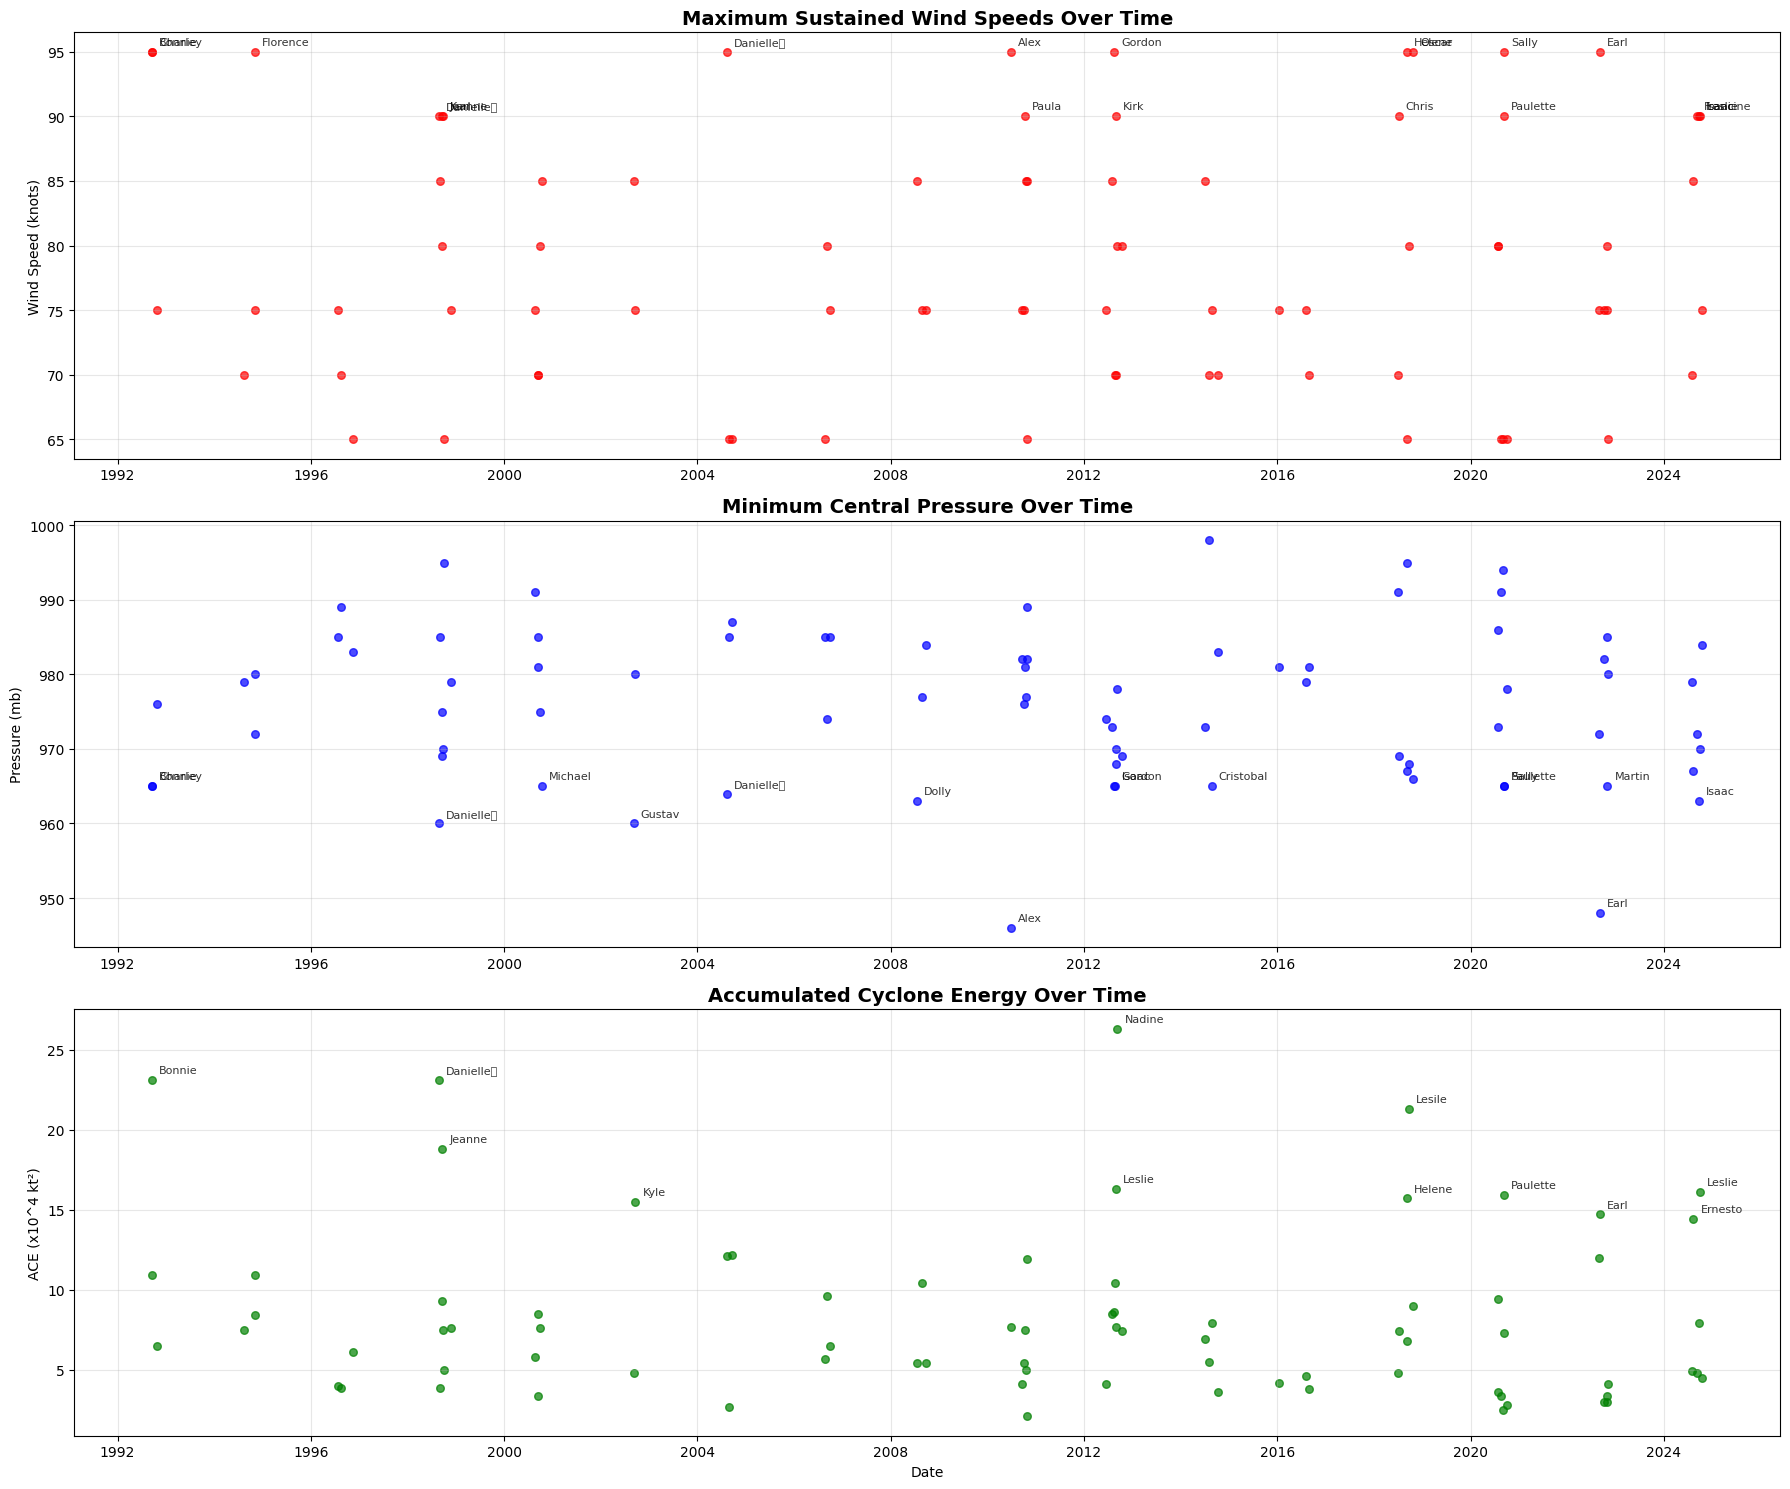

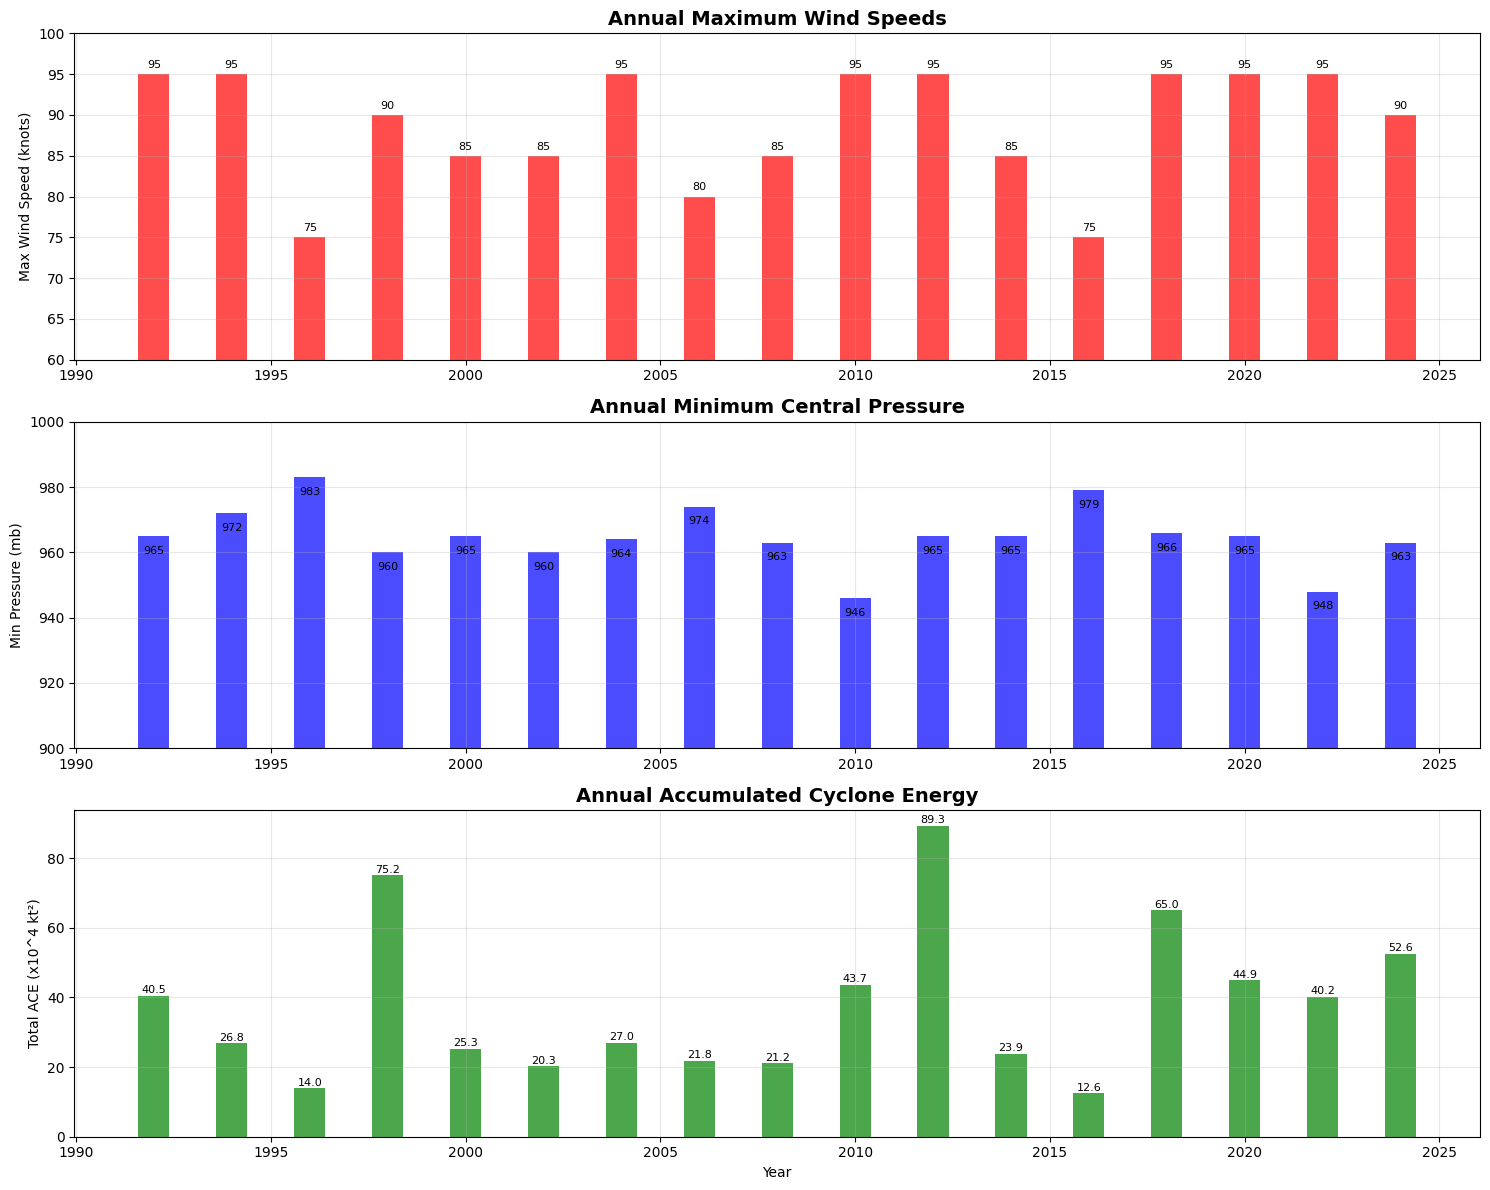


Basic Statistics:
Maximum Wind Speeds:
  Max: 95 knots
  Min: 65 knots
  Mean: 79.05 knots

Minimum Central Pressure:
  Max: 998 mb
  Min: 946 mb
  Mean: 975.92 mb

Accumulated Cyclone Energy:
  Max: 26.3
  Min: 2.1
  Mean: 8.2603


In [ ]:
# Function to parse hurricane dates (handles ranges like "03 Aug–08 Aug")
def parse_hurricane_date(date_str):
    """
    Parse hurricane date strings that might be ranges.
    For ranges, we'll use the start date.
    """
    if pd.isna(date_str):
        return pd.NaT

    # Convert to string if it's not already
    date_str = str(date_str)

    # Handle date ranges (e.g., "03 Aug–08 Aug")
    if '–' in date_str or '-' in date_str:
        # Split on the range character and take the first part
        if '–' in date_str:  # en dash
            start_date = date_str.split('–')[0].strip()
        else:  # regular hyphen
            start_date = date_str.split('-')[0].strip()

        # Add year (we'll need to handle this - might need to get from Year column)
        return start_date
    else:
        return date_str

# Apply the parsing function
df['Date_parsed'] = df['Date'].apply(parse_hurricane_date)

# We need to combine with year information since dates don't include year
# Create a proper datetime by combining with Year column
def create_full_date(row):
    """
    Create a proper datetime by combining parsed date with year
    """
    try:
        if pd.isna(row['Date_parsed']) or pd.isna(row['Year']):
            return pd.NaT

        date_str = str(row['Date_parsed']).strip()
        year = int(row['Year'])

        # Try different date formats
        formats_to_try = [
            '%d %b',  # "03 Aug"
            '%b %d',  # "Aug 03" (if format is different)
            '%d %B',  # "03 August"
            '%B %d',  # "August 03"
        ]

        for fmt in formats_to_try:
            try:
                # Parse the date without year
                date_obj = pd.to_datetime(date_str + f' {year}', format=f'{fmt} %Y')
                return date_obj
            except:
                continue

        # If none of the formats work, return NaT
        return pd.NaT

    except Exception as e:
        print(f"Error parsing date: {row['Date_parsed']} with year {row['Year']}: {e}")
        return pd.NaT

# Apply the date creation function
df['Date_datetime'] = df.apply(create_full_date, axis=1)

# Remove rows where date parsing failed
df_clean = df.dropna(subset=['Date_datetime']).copy()

print(f"\nOriginal dataset: {len(df)} rows")
print(f"After date cleaning: {len(df_clean)} rows")

# Sort by date to ensure proper time series
df_clean = df_clean.sort_values('Date_datetime')

# Create time series plots with hurricane names
fig, axes = plt.subplots(3, 1, figsize=(18, 15))

# 1. Maximum Sustained Wind Speeds time series with labels
scatter1 = axes[0].scatter(df_clean['Date_datetime'], df_clean['Maximun Sustained Wind Speeds (knots)'],
               alpha=0.7, color='red', s=30)
axes[0].set_title('Maximum Sustained Wind Speeds Over Time', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Wind Speed (knots)')
axes[0].grid(True, alpha=0.3)

# Add hurricane names as labels (for a subset to avoid overcrowding)
# We'll label only the strongest hurricanes to avoid too many labels
strong_wind_threshold = df_clean['Maximun Sustained Wind Speeds (knots)'].quantile(0.85)
strong_wind_storms = df_clean[df_clean['Maximun Sustained Wind Speeds (knots)'] >= strong_wind_threshold]

for idx, row in strong_wind_storms.iterrows():
    axes[0].annotate(row['Hurricane Name'],
                    (row['Date_datetime'], row['Maximun Sustained Wind Speeds (knots)']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

# 2. Minimum Central Pressure time series with labels
scatter2 = axes[1].scatter(df_clean['Date_datetime'], df_clean['Minimium Central Pressure (mb)'],
               alpha=0.7, color='blue', s=30)
axes[1].set_title('Minimum Central Pressure Over Time', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Pressure (mb)')
axes[1].grid(True, alpha=0.3)

# Add hurricane names as labels (for the lowest pressure storms)
low_pressure_threshold = df_clean['Minimium Central Pressure (mb)'].quantile(0.15)
low_pressure_storms = df_clean[df_clean['Minimium Central Pressure (mb)'] <= low_pressure_threshold]

for idx, row in low_pressure_storms.iterrows():
    axes[1].annotate(row['Hurricane Name'],
                    (row['Date_datetime'], row['Minimium Central Pressure (mb)']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

# 3. Accumulated Cyclone Energy time series with labels
scatter3 = axes[2].scatter(df_clean['Date_datetime'], df_clean['Accumulated Cyclone Energy (x10^4 kt^2)'],
               alpha=0.7, color='green', s=30)
axes[2].set_title('Accumulated Cyclone Energy Over Time', fontsize=14, fontweight='bold')
axes[2].set_ylabel('ACE (x10^4 kt²)')
axes[2].set_xlabel('Date')
axes[2].grid(True, alpha=0.3)

# Add hurricane names as labels (for highest ACE storms)
high_ace_threshold = df_clean['Accumulated Cyclone Energy (x10^4 kt^2)'].quantile(0.85)
high_ace_storms = df_clean[df_clean['Accumulated Cyclone Energy (x10^4 kt^2)'] >= high_ace_threshold]

for idx, row in high_ace_storms.iterrows():
    axes[2].annotate(row['Hurricane Name'],
                    (row['Date_datetime'], row['Accumulated Cyclone Energy (x10^4 kt^2)']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

plt.tight_layout()
plt.show()

# Optional: Create yearly aggregated plots to see trends better
df_clean['Year'] = df_clean['Date_datetime'].dt.year

# Group by year and calculate annual statistics
annual_stats = df_clean.groupby('Year').agg({
    'Maximun Sustained Wind Speeds (knots)': 'max',
    'Minimium Central Pressure (mb)': 'min',
    'Accumulated Cyclone Energy (x10^4 kt^2)': 'sum'
}).reset_index()

# Create annual trend plots with custom y-axis ranges
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Annual maximum wind speeds with y-axis from 60 to 100
axes[0].bar(annual_stats['Year'], annual_stats['Maximun Sustained Wind Speeds (knots)'],
            color='red', alpha=0.7)
axes[0].set_title('Annual Maximum Wind Speeds', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Max Wind Speed (knots)')
axes[0].set_ylim(60, 100)  # Custom y-axis range
axes[0].grid(True, alpha=0.3)

# Add value labels on top of bars for wind speed
for i, v in enumerate(annual_stats['Maximun Sustained Wind Speeds (knots)']):
    axes[0].text(annual_stats['Year'][i], v + 0.5, str(int(v)),
                ha='center', va='bottom', fontsize=8)

# Annual minimum pressure with y-axis from 900 to 1000
axes[1].bar(annual_stats['Year'], annual_stats['Minimium Central Pressure (mb)'],
            color='blue', alpha=0.7)
axes[1].set_title('Annual Minimum Central Pressure', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Min Pressure (mb)')
axes[1].set_ylim(900, 1000)  # Custom y-axis range
axes[1].grid(True, alpha=0.3)

# Add value labels on top of bars for pressure
for i, v in enumerate(annual_stats['Minimium Central Pressure (mb)']):
    axes[1].text(annual_stats['Year'][i], v - 3, str(int(v)),
                ha='center', va='top', fontsize=8)

# Annual total ACE (keep original scale)
axes[2].bar(annual_stats['Year'], annual_stats['Accumulated Cyclone Energy (x10^4 kt^2)'],
            color='green', alpha=0.7)
axes[2].set_title('Annual Accumulated Cyclone Energy', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Total ACE (x10^4 kt²)')
axes[2].set_xlabel('Year')
axes[2].grid(True, alpha=0.3)

# Add value labels on top of bars for ACE
for i, v in enumerate(annual_stats['Accumulated Cyclone Energy (x10^4 kt^2)']):
    axes[2].text(annual_stats['Year'][i], v + 0.1, f'{v:.1f}',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Display some basic statistics
print("\nBasic Statistics:")
print("Maximum Wind Speeds:")
print(f"  Max: {df_clean['Maximun Sustained Wind Speeds (knots)'].max()} knots")
print(f"  Min: {df_clean['Maximun Sustained Wind Speeds (knots)'].min()} knots")
print(f"  Mean: {df_clean['Maximun Sustained Wind Speeds (knots)'].mean():.2f} knots")

print("\nMinimum Central Pressure:")
print(f"  Max: {df_clean['Minimium Central Pressure (mb)'].max()} mb")
print(f"  Min: {df_clean['Minimium Central Pressure (mb)'].min()} mb")
print(f"  Mean: {df_clean['Minimium Central Pressure (mb)'].mean():.2f} mb")

print("\nAccumulated Cyclone Energy:")
print(f"  Max: {df_clean['Accumulated Cyclone Energy (x10^4 kt^2)'].max()}")
print(f"  Min: {df_clean['Accumulated Cyclone Energy (x10^4 kt^2)'].min()}")
print(f"  Mean: {df_clean['Accumulated Cyclone Energy (x10^4 kt^2)'].mean():.4f}")

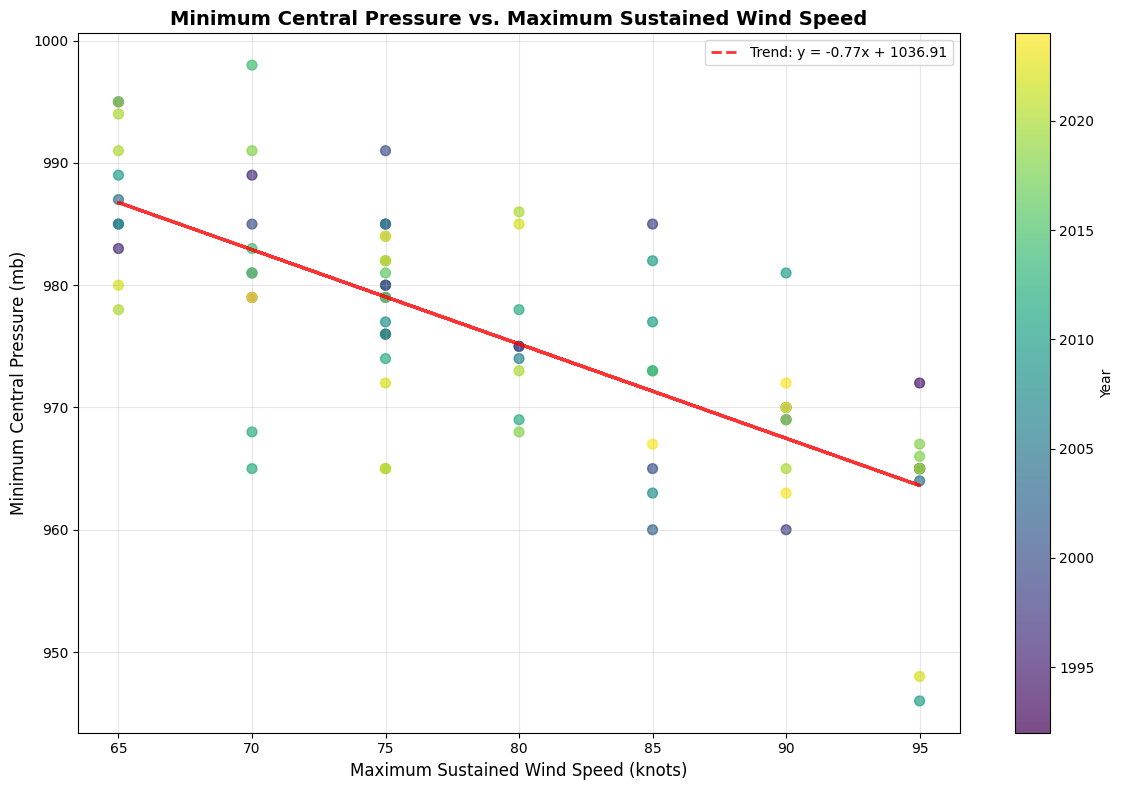

Correlation between wind speed and pressure: -0.729


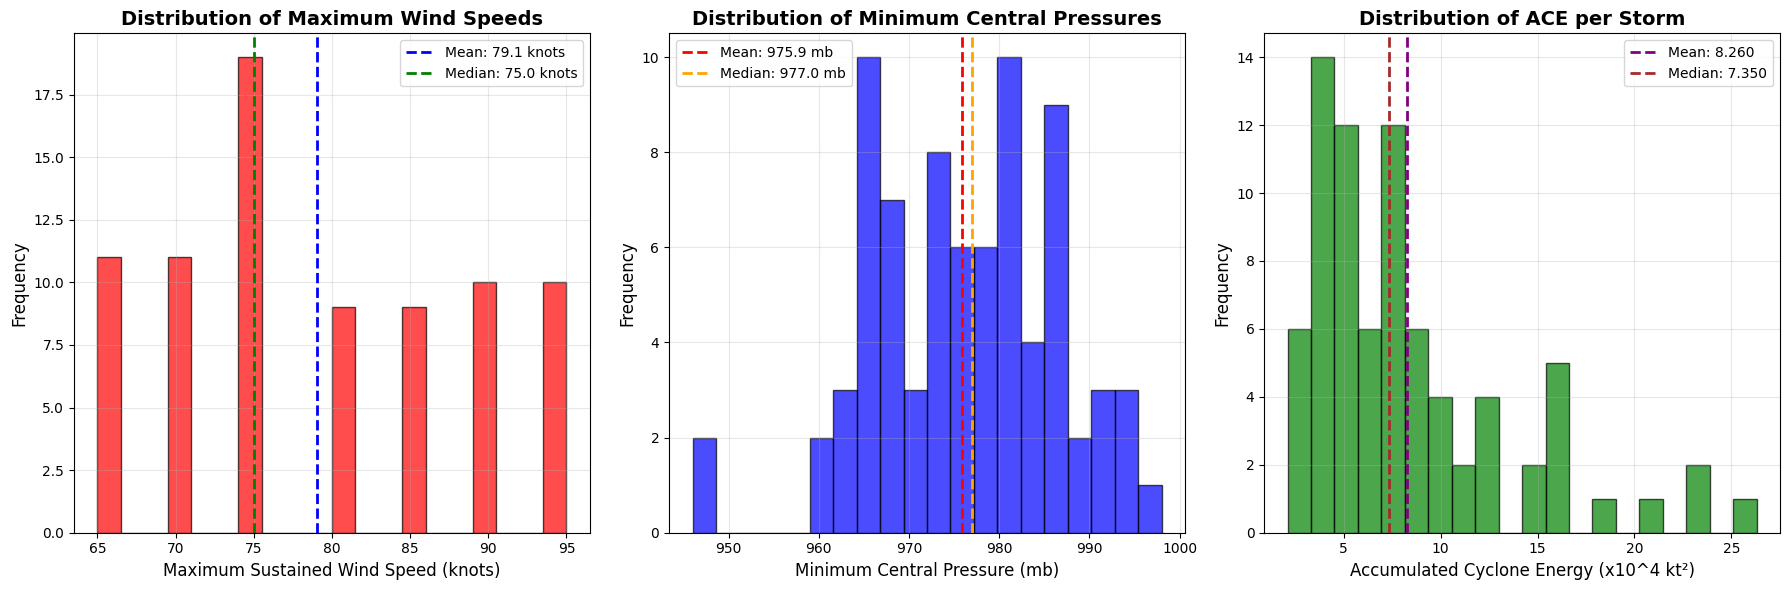


DETAILED DISTRIBUTION STATISTICS

MAXIMUM SUSTAINED WIND SPEEDS (knots):
Mean: 79.05
Median: 75.00
Standard Deviation: 9.78
Minimum: 65.0
Maximum: 95.0
25th percentile: 70.0
75th percentile: 87.5

MINIMUM CENTRAL PRESSURE (mb):
Mean: 975.92
Median: 977.00
Standard Deviation: 10.35
Minimum: 946.0
Maximum: 998.0
25th percentile: 968.0
75th percentile: 983.5

ACCUMULATED CYCLONE ENERGY (x10^4 kt²):
Mean: 8.2603
Median: 7.3500
Standard Deviation: 5.2365
Minimum: 2.1000
Maximum: 26.3000
25th percentile: 4.5250
75th percentile: 10.2000


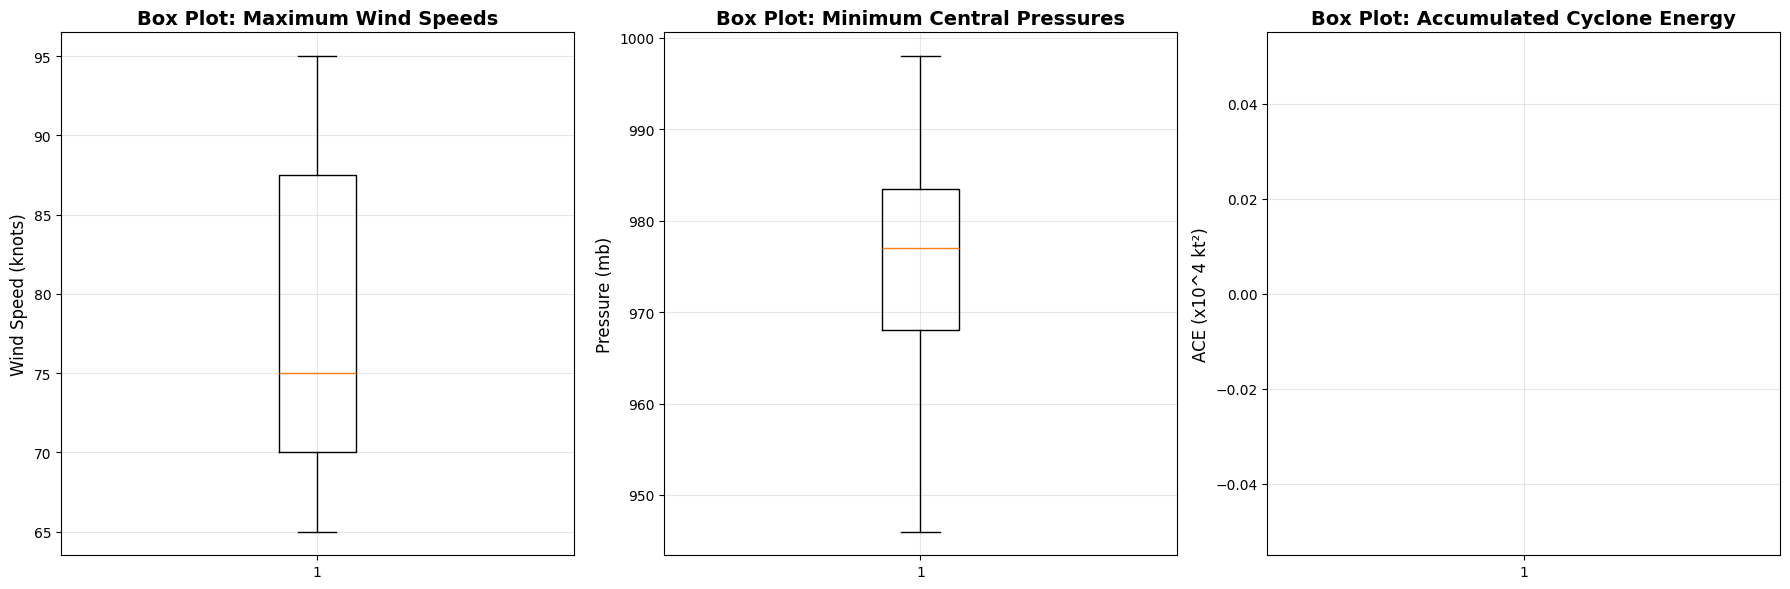

In [ ]:
# Create the scatter plot: Minimum Central Pressure vs. Maximum Sustained Winds
plt.figure(figsize=(12, 8))

# Scatter plot with color coding by year (optional)
scatter = plt.scatter(df_clean['Maximun Sustained Wind Speeds (knots)'],
                     df_clean['Minimium Central Pressure (mb)'],
                     c=df_clean['Year'],
                     cmap='viridis',
                     alpha=0.7,
                     s=50)

plt.colorbar(scatter, label='Year')
plt.xlabel('Maximum Sustained Wind Speed (knots)', fontsize=12)
plt.ylabel('Minimum Central Pressure (mb)', fontsize=12)
plt.title('Minimum Central Pressure vs. Maximum Sustained Wind Speed', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(df_clean['Maximun Sustained Wind Speeds (knots)'],
               df_clean['Minimium Central Pressure (mb)'], 1)
p = np.poly1d(z)
plt.plot(df_clean['Maximun Sustained Wind Speeds (knots)'],
         p(df_clean['Maximun Sustained Wind Speeds (knots)']),
         "r--", alpha=0.8, linewidth=2, label=f'Trend: y = {z[0]:.2f}x + {z[1]:.2f}')

plt.legend()
plt.tight_layout()
plt.show()

# Calculate correlation coefficient
correlation = df_clean['Maximun Sustained Wind Speeds (knots)'].corr(df_clean['Minimium Central Pressure (mb)'])
print(f"Correlation between wind speed and pressure: {correlation:.3f}")

# Create histograms for distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Distribution of Maximum Wind Speeds
axes[0].hist(df_clean['Maximun Sustained Wind Speeds (knots)'],
             bins=20, color='red', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Maximum Sustained Wind Speed (knots)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Maximum Wind Speeds', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Add statistics to the wind speed histogram
wind_mean = df_clean['Maximun Sustained Wind Speeds (knots)'].mean()
wind_median = df_clean['Maximun Sustained Wind Speeds (knots)'].median()
wind_std = df_clean['Maximun Sustained Wind Speeds (knots)'].std()

axes[0].axvline(wind_mean, color='blue', linestyle='--', linewidth=2,
                label=f'Mean: {wind_mean:.1f} knots')
axes[0].axvline(wind_median, color='green', linestyle='--', linewidth=2,
                label=f'Median: {wind_median:.1f} knots')
axes[0].legend()

# 2. Distribution of Minimum Central Pressures
axes[1].hist(df_clean['Minimium Central Pressure (mb)'],
             bins=20, color='blue', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Minimum Central Pressure (mb)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Minimum Central Pressures', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Add statistics to the pressure histogram
pressure_mean = df_clean['Minimium Central Pressure (mb)'].mean()
pressure_median = df_clean['Minimium Central Pressure (mb)'].median()
pressure_std = df_clean['Minimium Central Pressure (mb)'].std()

axes[1].axvline(pressure_mean, color='red', linestyle='--', linewidth=2,
                label=f'Mean: {pressure_mean:.1f} mb')
axes[1].axvline(pressure_median, color='orange', linestyle='--', linewidth=2,
                label=f'Median: {pressure_median:.1f} mb')
axes[1].legend()

# 3. Distribution of ACE per storm
axes[2].hist(df_clean['Accumulated Cyclone Energy (x10^4 kt^2)'],
             bins=20, color='green', alpha=0.7, edgecolor='black')
axes[2].set_xlabel('Accumulated Cyclone Energy (x10^4 kt²)', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].set_title('Distribution of ACE per Storm', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

# Add statistics to the ACE histogram
ace_mean = df_clean['Accumulated Cyclone Energy (x10^4 kt^2)'].mean()
ace_median = df_clean['Accumulated Cyclone Energy (x10^4 kt^2)'].median()
ace_std = df_clean['Accumulated Cyclone Energy (x10^4 kt^2)'].std()

axes[2].axvline(ace_mean, color='purple', linestyle='--', linewidth=2,
                label=f'Mean: {ace_mean:.3f}')
axes[2].axvline(ace_median, color='brown', linestyle='--', linewidth=2,
                label=f'Median: {ace_median:.3f}')
axes[2].legend()

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n" + "="*60)
print("DETAILED DISTRIBUTION STATISTICS")
print("="*60)

print("\nMAXIMUM SUSTAINED WIND SPEEDS (knots):")
print(f"Mean: {wind_mean:.2f}")
print(f"Median: {wind_median:.2f}")
print(f"Standard Deviation: {wind_std:.2f}")
print(f"Minimum: {df_clean['Maximun Sustained Wind Speeds (knots)'].min():.1f}")
print(f"Maximum: {df_clean['Maximun Sustained Wind Speeds (knots)'].max():.1f}")
print(f"25th percentile: {df_clean['Maximun Sustained Wind Speeds (knots)'].quantile(0.25):.1f}")
print(f"75th percentile: {df_clean['Maximun Sustained Wind Speeds (knots)'].quantile(0.75):.1f}")

print("\nMINIMUM CENTRAL PRESSURE (mb):")
print(f"Mean: {pressure_mean:.2f}")
print(f"Median: {pressure_median:.2f}")
print(f"Standard Deviation: {pressure_std:.2f}")
print(f"Minimum: {df_clean['Minimium Central Pressure (mb)'].min():.1f}")
print(f"Maximum: {df_clean['Minimium Central Pressure (mb)'].max():.1f}")
print(f"25th percentile: {df_clean['Minimium Central Pressure (mb)'].quantile(0.25):.1f}")
print(f"75th percentile: {df_clean['Minimium Central Pressure (mb)'].quantile(0.75):.1f}")

print("\nACCUMULATED CYCLONE ENERGY (x10^4 kt²):")
print(f"Mean: {ace_mean:.4f}")
print(f"Median: {ace_median:.4f}")
print(f"Standard Deviation: {ace_std:.4f}")
print(f"Minimum: {df_clean['Accumulated Cyclone Energy (x10^4 kt^2)'].min():.4f}")
print(f"Maximum: {df_clean['Accumulated Cyclone Energy (x10^4 kt^2)'].max():.4f}")
print(f"25th percentile: {df_clean['Accumulated Cyclone Energy (x10^4 kt^2)'].quantile(0.25):.4f}")
print(f"75th percentile: {df_clean['Accumulated Cyclone Energy (x10^4 kt^2)'].quantile(0.75):.4f}")

# Additional: Create box plots for the same distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Box plot for wind speeds
axes[0].boxplot(df_clean['Maximun Sustained Wind Speeds (knots)'])
axes[0].set_ylabel('Wind Speed (knots)', fontsize=12)
axes[0].set_title('Box Plot: Maximum Wind Speeds', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Box plot for pressures
axes[1].boxplot(df_clean['Minimium Central Pressure (mb)'])
axes[1].set_ylabel('Pressure (mb)', fontsize=12)
axes[1].set_title('Box Plot: Minimum Central Pressures', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Box plot for ACE
axes[2].boxplot(df_clean['Accumulated Cyclone Energy (x10^4 kt^2)'])
axes[2].set_ylabel('ACE (x10^4 kt²)', fontsize=12)
axes[2].set_title('Box Plot: Accumulated Cyclone Energy', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()